In [1]:
!pip3 install scikit-learn

You should consider upgrading via the '/Volumes/Kerja_Keras/Folder_Fold_Recovery/For Learning/Bootcamp Binar/GoldChallange_Binar/gold_binar/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
btc = yf.download('BTC-USD', start='2010-01-01')
gold = yf.download('GC=F',start = '2010-01-01')
sp500 = yf.download('^GSPC', start='2010-01-01')
nasdaq = yf.download('^IXIC', start='2010-01-01')
usm2 = pd.read_csv("M2SL.csv")

usm2['DATE'] = pd.to_datetime(usm2['DATE'])
usm2 = usm2.set_index('DATE')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.concat([btc['Adj Close'], gold['Adj Close'], sp500['Adj Close'], nasdaq['Adj Close']], axis=1)
df = pd.concat([df,usm2['M2SL']],axis=1)
df.columns = ['BTC', 'Gold', 'S&P500', 'NASDAQ','M2SL']

In [5]:
df.dropna(inplace = True)

In [6]:
df

,BTC,Gold,S&P500,NASDAQ,M2SL
2014-10-01,383.614990,1214.599976,1946.160034,4422.089844,11566.0
2014-12-01,379.244995,1218.000000,2053.439941,4727.350098,11684.9
2015-04-01,247.272003,1208.099976,2059.689941,4880.229980,11928.9
2015-05-01,232.078995,1174.500000,2108.290039,5005.390137,11957.9
2015-06-01,222.925995,1188.300049,2111.729980,5082.930176,12001.7
...,...,...,...,...,...
2022-09-01,20127.140625,1696.599976,3966.850098,11785.129883,21523.1
2022-11-01,20485.273438,1645.000000,3856.100098,10890.849609,21396.9
2022-12-01,16967.132812,1801.099976,4076.570068,11482.450195,21357.7
2023-02-01,23723.769531,1927.800049,4119.209961,11816.320312,21075.4


In [7]:
perubahan_btc = ((df['BTC'][-1]-df['BTC'][0])/df['BTC'][0])*100
perubahan_gold = ((df['Gold'][-1]-df['Gold'][0])/df['Gold'][0])*100
perubahan_sp500 = ((df['S&P500'][-1]-df['S&P500'][0])/df['S&P500'][0])*100
perubahan_nasdaq = ((df['NASDAQ'][-1]-df['NASDAQ'][0])/df['NASDAQ'][0])*100
perubahan_M2SL = ((df['M2SL'][-1]-df['M2SL'][0])/usm2['M2SL'][0])*100

In [8]:
list_Asset = ['BTC','GOLD','SP500','NASDAQ','M2SL']
nilai_perubahan = [perubahan_btc,perubahan_gold,perubahan_sp500,perubahan_nasdaq,perubahan_M2SL]

Text(0, 0.5, 'Presentase Perubahan % \n Since 2014-10-01 until 2023-03-01 ')

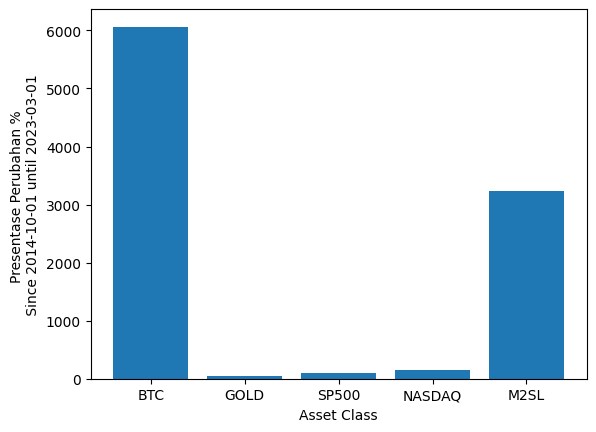

In [9]:
plt.figure(1)
plt.bar(list_Asset,nilai_perubahan)
plt.xlabel("Asset Class")
plt.ylabel("Presentase Perubahan % \n Since 2014-10-01 until 2023-03-01 ")

In [10]:
# Mencari Korelasi Antara Asset Tersebut

In [11]:
corr = df.corr()

In [12]:
corr

,BTC,Gold,S&P500,NASDAQ,M2SL
BTC,1.000000,0.766714,0.897872,0.918841,0.837029
Gold,0.766714,1.000000,0.896406,0.911007,0.945620
S&P500,0.897872,0.896406,1.000000,0.984172,0.962452
NASDAQ,0.918841,0.911007,0.984172,1.000000,0.951484
M2SL,0.837029,0.945620,0.962452,0.951484,1.000000


Text(0.5, 1.0, 'Heat-map Korelasi Silang Antar Asset')

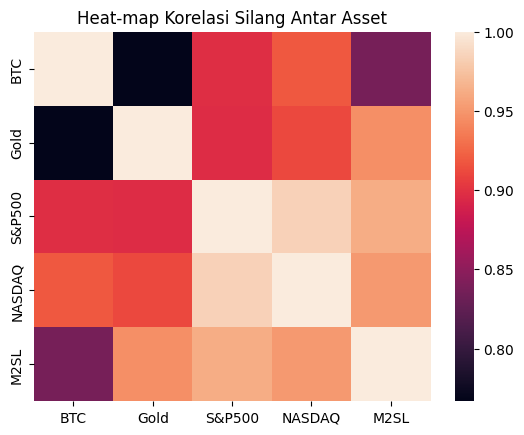

In [13]:
plt.title(2)
sns.heatmap(corr)
plt.title("Heat-map Korelasi Silang Antar Asset")

In [14]:
# Prediksi Harga Bitcoin Menggunakan Tensorflow

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

2023-05-07 23:53:41.763433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [17]:
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [18]:
x = df.index
y = df['BTC'].values
y -=np.min(y)
y /=np.max(y)

In [19]:
split_time = int(len(x)*0.8)

In [20]:
y_train = y[:split_time]
y_test = y[split_time:]

X_train,Y_train = create_dataset(y_train,7)
X_test,Y_test = create_dataset(y_test,7)

In [21]:
plt.plot(x_train,y_train)
plt.plot(x_test,y_test)

NameError: name 'x_train' is not defined

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=1.0000e-04, momentum=0.9),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(Y_train,epochs=25,verbose=1,validation_data=(Y_test))

In [ ]:
model.predict(X_test)